# Traditional Machine Learning Models

## Baseline Model

During Exploratory Data Analysis phase we trained a baseline **LogisticRegresion Model** which showed an accuracy score of 85% but a Recall score of 15%. This was primarily due to class imbalance. In this phase we will perform several steps to tune and identify the best model to predict the occurence of diabetes.

## Specifying the imports

In [19]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import time
import numpy as np

import warnings

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.inspection import permutation_importance

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.preprocessing import RobustScaler,StandardScaler


from sklearn.model_selection import GridSearchCV

### General Settings

In [2]:
# Set display options 
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

# ignore warnings
warnings.filterwarnings('ignore')


## Reading the Data

In [3]:
# Load BRFS csv into a dataframe
df = pd.read_csv('data/diabetes_012_health_indicators_BRFSS2015.csv')
df.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [4]:
df.shape

(253680, 22)

In [5]:
numeric_features = ["BMI","MentHlth","PhysHlth"]
bin_clinical_features = ["HighBP","HighChol","CholCheck","Stroke","HeartDiseaseorAttack","DiffWalk","Sex"]
bin_lifestyle_features = ["Smoker","PhysActivity","Fruits","Veggies","HvyAlcoholConsump"]
ordinal_lifestyle_features = ["Education","Income","Age","GenHlth"]

## Preparing the Data

### During EDA Phase we have already established that the data
    1. Has no columns with missing values 
    2. Has no binary clinical features with Out of Range values 
    3. Has no binary lifestyle features with Out of Range values 
    4. Has no ordinal lifestyle features with Out of Range values


In [6]:
# Check for duplicate values 
dup_count = df.duplicated().sum()
print ("number of duplicate rows",dup_count)

# Remove the duplicates 
df =df.drop_duplicates()
df.shape

number of duplicate rows 23899


(229781, 22)

### Prepare the target variable

In [7]:
# 0 --> No Diabetes
# 1 --> Pre Diabetes
# 2 --> Diabetes
diabetes_labels = {0: 'No Diabetes', 1: 'Pre Diabetes', 2: 'Diabetes'}

#Create a new target variable to show presence of diabetes
df['Diabetes Prevalent'] = (df['Diabetes_012'] == 2).astype(int)

## Feature Engineering

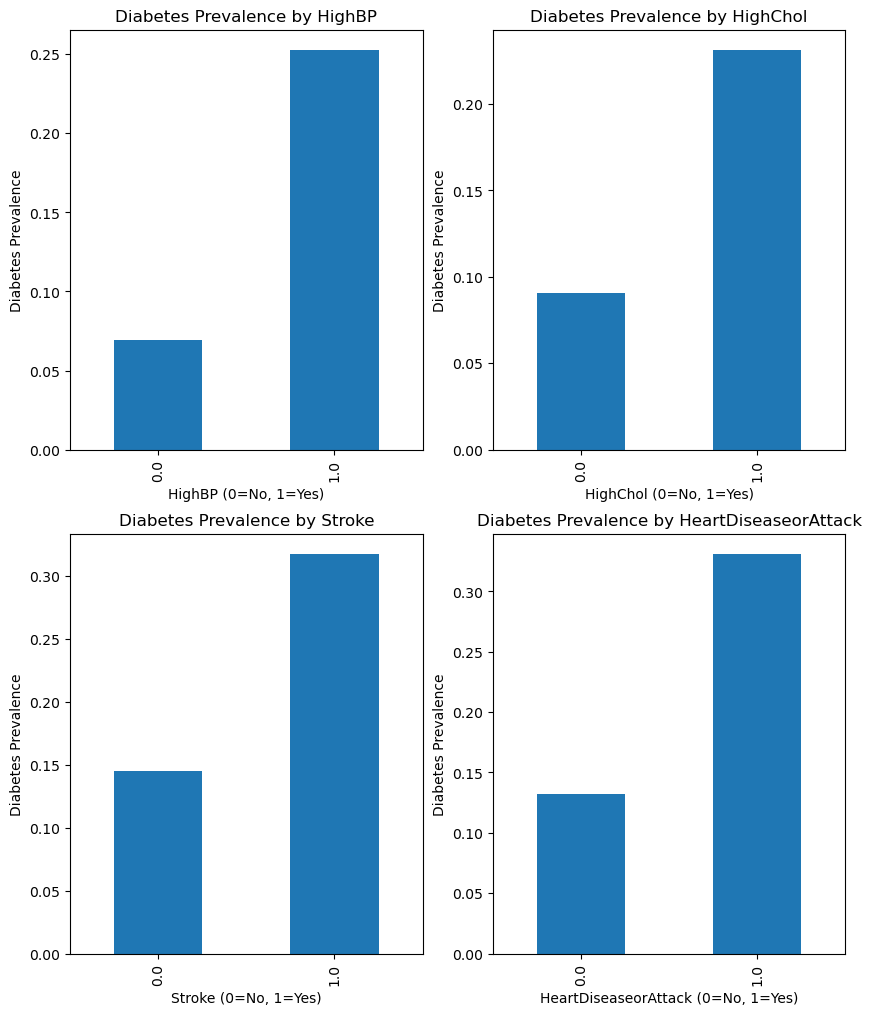

In [8]:
# Amongst the clinical features , lets use the features that can be classified 
# as clinical markers
bin_clinical_markers = ["HighBP","HighChol","Stroke","HeartDiseaseorAttack"]

# We will create a combined bar plot of clinical markers showing individual impact
fig, axes = plt.subplots(2,2,figsize=(10,12))
axes = axes.flatten()

for axis,column in zip(axes,bin_clinical_markers):
    prevalence = df.groupby(column)['Diabetes Prevalent'].mean()
    prevalence.plot(kind='bar', ax=axis)
    axis.set_title(f'Diabetes Prevalence by {column}')
    axis.set_xlabel(f'{column} (0=No, 1=Yes)')
    axis.set_ylabel('Diabetes Prevalence')
    
plt.savefig("images/clinical_markers.png", dpi =300)
plt.show()



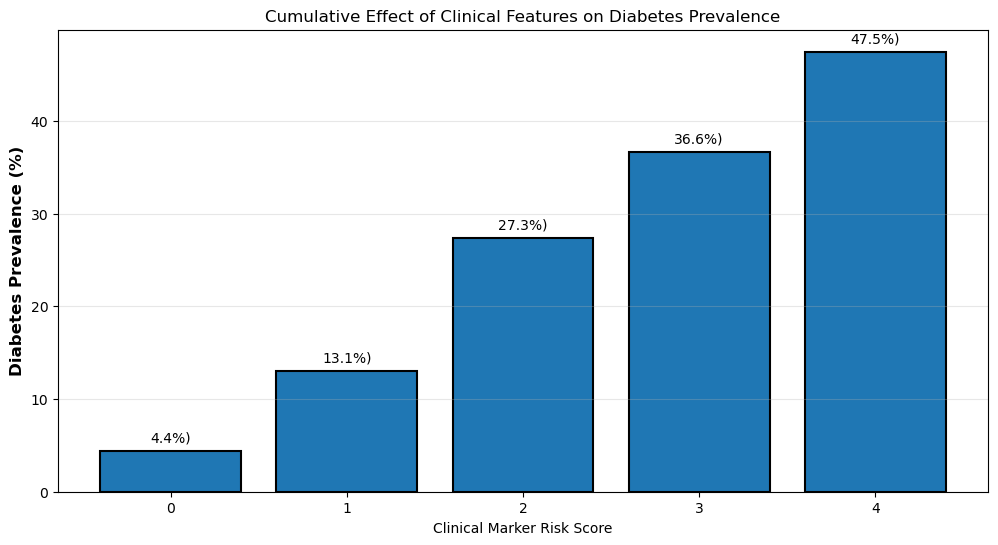

In [9]:
# Let us now plot the cumulative effect of the clinical features
plt.figure(figsize=(12, 6))

# Create a clinical_markers_risk column from the clinical marker features
plot_df = df.copy()
plot_df['ClinicalMarkerRisk'] = (
    df['HighBP'] + 
    df['HighChol'] + 
    df['HeartDiseaseorAttack'] + 
    df['Stroke']
)

clinical_marker_risk = plot_df.groupby('ClinicalMarkerRisk')['Diabetes Prevalent'].agg(['mean', 'count'])
clinical_marker_risk['percentage'] = clinical_marker_risk['mean']*100

bar_plot = plt.bar(clinical_marker_risk.index, clinical_marker_risk['percentage'], edgecolor='black', linewidth=1.5)

for i, (idx, row) in enumerate(clinical_marker_risk.iterrows()):
    plt.text(idx, row['percentage'] + 1, 
             f"{row['percentage']:.1f}%)", 
             ha='center')

plt.xlabel('Clinical Marker Risk Score')
plt.ylabel('Diabetes Prevalence (%)', fontsize=12, fontweight='bold')
plt.title('Cumulative Effect of Clinical Features on Diabetes Prevalence')
plt.grid(axis='y', alpha=0.3)
plt.savefig("images/cumulative_clinical_markers.png", dpi =300)
plt.show()



In [10]:
# Add interaction features 

# Interaction feature for Clinical Markers 
df['ClinicalMarkerRisk']= (
    df['HighBP'] + 
    df['HighChol'] + 
    df['HeartDiseaseorAttack'] + 
    df['Stroke']
)    

# Interaction features for Lifestyle Markers 
df['LifestyleMarkerRisk'] = (
    df['PhysActivity'] +      # Positive trait
    df['Fruits'] +            # Positive trait
    df['Veggies'] -           # Positive trait
    df['Smoker'] -            # Negative trait
    df['HvyAlcoholConsump']   # Negative trait
)

# Interaction between Age and BMI
df['AgeBMIMarkerRisk'] = df['Age'] * df['BMI']

# Interaction depciting sedentary lifestyle - high BMI and no physical activity
df['BMISedentaryMarkerRisk'] = df['BMI'] * (1 - df['PhysActivity']) 

interaction_features =['ClinicalMarkerRisk','LifestyleMarkerRisk','AgeBMIMarkerRisk','BMISedentaryMarkerRisk']
df.info()



<class 'pandas.core.frame.DataFrame'>
Index: 229781 entries, 0 to 253679
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Diabetes_012            229781 non-null  float64
 1   HighBP                  229781 non-null  float64
 2   HighChol                229781 non-null  float64
 3   CholCheck               229781 non-null  float64
 4   BMI                     229781 non-null  float64
 5   Smoker                  229781 non-null  float64
 6   Stroke                  229781 non-null  float64
 7   HeartDiseaseorAttack    229781 non-null  float64
 8   PhysActivity            229781 non-null  float64
 9   Fruits                  229781 non-null  float64
 10  Veggies                 229781 non-null  float64
 11  HvyAlcoholConsump       229781 non-null  float64
 12  AnyHealthcare           229781 non-null  float64
 13  NoDocbcCost             229781 non-null  float64
 14  GenHlth                 2

## Model Selection and Comparision

In [11]:
# Lets use the combination of existing and engineered features for model training 
total_features = numeric_features + bin_clinical_features + bin_lifestyle_features + ordinal_lifestyle_features + interaction_features

# Prepare the data
X = df[total_features]
y = df['Diabetes Prevalent']

### Train/Test Split

In [12]:
# Split with 20% test size 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Create a pre-processor with a RobustScaler for numerical columns
# and a passthrough for all lifestyle features 
preprocessor = ColumnTransformer([
    ('num', RobustScaler(), numeric_features),
    ('pass', 'passthrough', bin_clinical_features + bin_lifestyle_features + ordinal_lifestyle_features+interaction_features)
])

## Model Classifier Comparision

In [14]:
# We will use the following models 
# 1. Logistic regression with L2 regularization
# 2. DecisionTreeClassifier
# 3. RandomForestClassifier
# 4. GradientBoostingClassifier  
# 5. SVM  (We will train this separately on a smaller dataset)
# 6. Gaussian Naive Bayes 
models = {
    'Logistic Regression': LogisticRegression(
        penalty='l2',
        class_weight='balanced', #compensate for class imbalance in data
        max_iter=5000,
        random_state=42
    ),
    'Decision Tree': DecisionTreeClassifier(
        class_weight='balanced', #compensate for class imbalance in data
        max_depth=10,
        min_samples_split=20,
        min_samples_leaf=10,
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced', #compensate for class imbalance in data
        random_state=42,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        random_state=42
    ),    
    'Naive Bayes': GaussianNB()
}



In [15]:
# Run the pipeline on each of the models 
results = []

for name, model in models.items():
    print("Now evaluating model with name:",name)
    start_time = time.time()
    
    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Train
    pipeline.fit(X_train, y_train)

    # Predict
    y_pred = pipeline.predict(X_test)
    if hasattr(pipeline, "predict_proba"):
      y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
    else:
      y_pred_prob = None

    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1-Score': f1_score(y_test, y_pred, zero_division=0),
        'ROC-AUC': roc_auc_score(y_test, y_pred_prob) if y_pred_prob is not None else None,
        'Training Time (s)': time.time() - start_time
    }
    
    print("Completed evaluating model with name:",name)
    results.append(metrics)     

Now evaluating model with name: Logistic Regression
Completed evaluating model with name: Logistic Regression
Now evaluating model with name: Decision Tree
Completed evaluating model with name: Decision Tree
Now evaluating model with name: Random Forest
Completed evaluating model with name: Random Forest
Now evaluating model with name: Gradient Boosting
Completed evaluating model with name: Gradient Boosting
Now evaluating model with name: Naive Bayes
Completed evaluating model with name: Naive Bayes


In [16]:
# SVM will take a large amount of time to train on the dataset. 
# So we will train SVM with a smaller sample 5% of the whoe dataset

X_train_sample = X_train.sample(n=int(len(X_train) * 0.05), random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='rbf', class_weight='balanced', 
                      probability=True, random_state=42))
])

start_time = time.time()
svm_pipeline.fit(X_train_sample, y_train_sample)
y_pred_svm = svm_pipeline.predict(X_test)
y_pred_proba_svm = svm_pipeline.predict_proba(X_test)[:, 1]

svm_metrics = {
    'Model': 'SVM (5% sample)',
    'Accuracy': accuracy_score(y_test, y_pred_svm),
    'Precision': precision_score(y_test, y_pred_svm, zero_division=0),
    'Recall': recall_score(y_test, y_pred_svm, zero_division=0),
    'F1-Score': f1_score(y_test, y_pred_svm, zero_division=0),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba_svm),
    'Training Time (s)': time.time() - start_time
}
results.append(svm_metrics)

# Create a data frame of the results
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Recall', ascending=False).reset_index(drop=True)
results_df

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Training Time (s)
0,Decision Tree,0.707749,0.309457,0.760634,0.439932,0.797126,0.375817
1,Logistic Regression,0.726266,0.324482,0.752415,0.453424,0.809609,12.041165
2,SVM (5% sample),0.645603,0.262519,0.745350,0.388282,0.755805,22.576852
3,Naive Bayes,0.755162,0.331433,0.611968,0.429990,0.779371,0.054030
4,Gradient Boosting,0.854342,0.561954,0.157606,0.246171,0.815491,10.566909
5,Random Forest,0.843005,0.441324,0.151839,0.225941,0.771944,1.252936


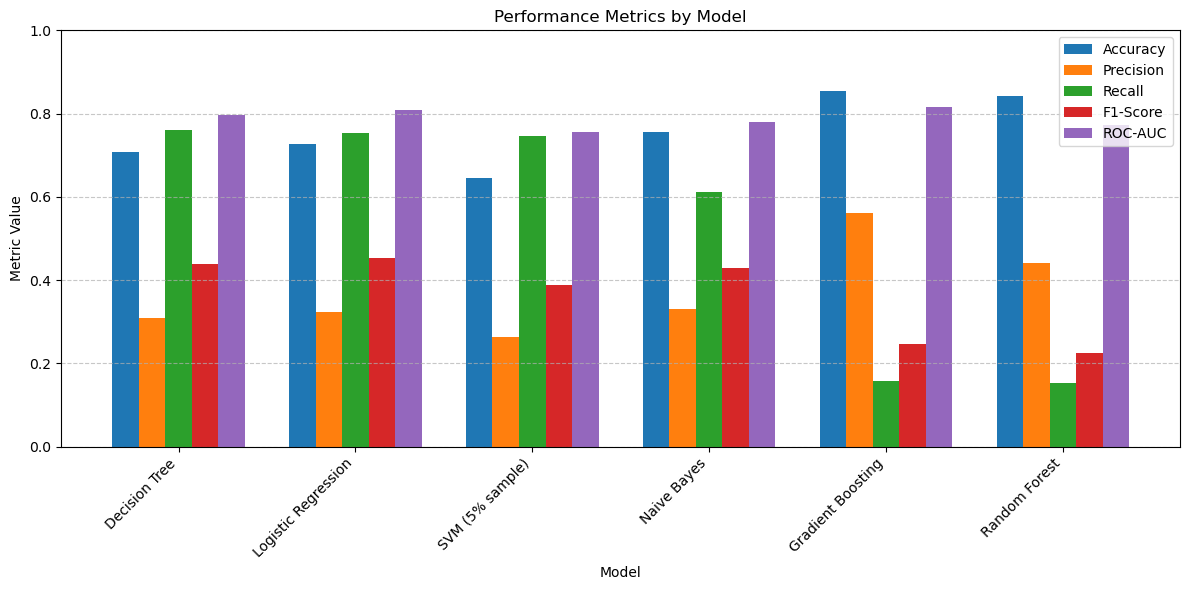

In [17]:
# Create a plot of metrics 

# Set up plot
metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]
x = np.arange(len(results_df["Model"])) 
width = 0.15  

fig, axis = plt.subplots(figsize=(12,6))

# Plot grouped bars
for i, metric in enumerate(metrics):
    axis.bar(x + i*width, results_df[metric], width, label=metric)

# Labels and title
axis.set_xlabel('Model')
axis.set_ylabel('Metric Value')
axis.set_title('Performance Metrics by Model')
axis.set_xticks(x + width*2)
axis.set_xticklabels(results_df["Model"], rotation=45, ha="right")
axis.set_ylim(0, 1) 
axis.grid(axis='y', linestyle='--', alpha=0.7)

# Legend
axis.legend()

plt.tight_layout()
plt.savefig("images/model_metrics.png", dpi =300)
plt.show()


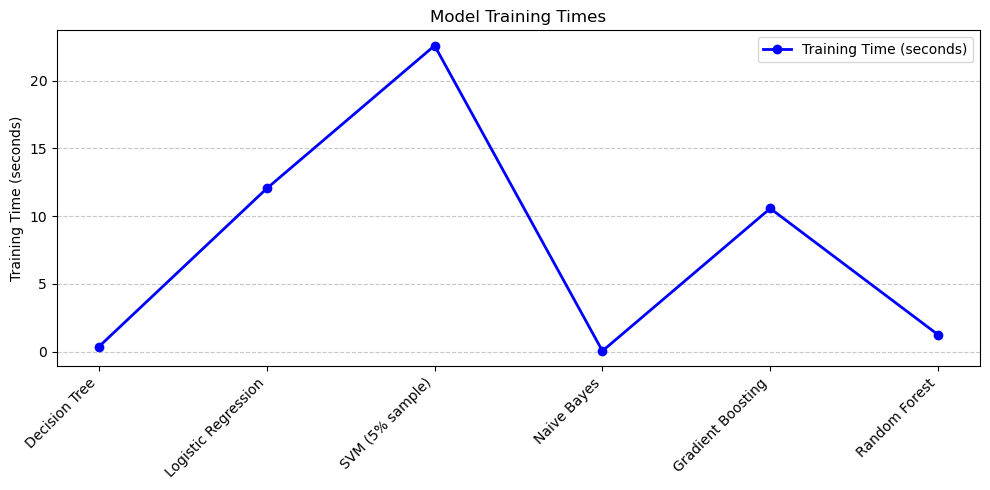

In [18]:

x = np.arange(len(results_df["Model"]))

plt.figure(figsize=(10,5))
plt.plot(x, results_df["Training Time (s)"], marker='o', linewidth=2, color='blue', label='Training Time (seconds)')

# Labels and title
plt.xticks(x, results_df["Model"], rotation=45, ha="right")
plt.ylabel("Training Time (seconds)")
plt.title("Model Training Times")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig("images/model_training_time.png", dpi =300)
plt.show()

In [21]:
#Compute cross Validation scores
cross_validation_results=[]
for name, model in models.items():
    # 5 Fold Cross validation
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='recall', n_jobs=-1)
    
    # Store results
    cross_validation_results.append({
        'Model': name,
        'Mean Recall': scores.mean(),
        'Std Dev': scores.std(),
        'Min': scores.min(),
        'Max': scores.max(),
        'All Folds': scores
    })
    
# Create summary DataFrame
cv_summary = pd.DataFrame(cross_validation_results)
cv_summary = cv_summary.sort_values('Mean Recall', ascending=False)
cv_summary

Exception ignored in: <function ResourceTracker.__del__ at 0x10829dc60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x102efdc60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1027a9c60>
Traceback (most recent call last

,Model,Mean Recall,Std Dev,Min,Max,All Folds
1,Decision Tree,0.767559,0.013445,0.750355,0.788707,"[0.7887073863636364, 0.7503551136363636, 0.7562577667317593, 0.7729451446831174, 0.76953125]"
0,Logistic Regression,0.750551,0.005608,0.740636,0.757102,"[0.7571022727272727, 0.7507102272727273, 0.7544825137582105, 0.7406355405645304, 0.7498224431818182]"
4,Naive Bayes,0.614197,0.005751,0.605716,0.621804,"[0.6193181818181818, 0.6116832386363636, 0.6124622758743121, 0.6057163145748269, 0.6218039772727273]"
3,Gradient Boosting,0.165791,0.002555,0.160838,0.167969,"[0.1669034090909091, 0.166015625, 0.16722883010829043, 0.160837919403515, 0.16796875]"
2,Random Forest,0.152759,0.003664,0.149680,0.159950,"[0.15181107954545456, 0.15110085227272727, 0.15995029291674062, 0.15125155334635185, 0.14968039772727273]"


## Hyperparameter Tuning 

**We will tune Decision tree, Logistic Regression and Naive Bayes with a Grid Search CV. We will not tune SVM as it will be extremly slow. We will also not tune Gradient Boosting and Random Forest as they have un-usable recall values.**

In [19]:
tuned_results=[]

# Perform Grid search CV on decision tree

param_grid = {
    'classifier__max_depth': [8, 10, 12, 15, None],
    'classifier__min_samples_split': [10, 20, 30, 50],
    'classifier__min_samples_leaf': [5, 10, 15, 20],
    'classifier__class_weight': ['balanced', {0: 1, 1: 8}, {0: 1, 1: 10}],
    'classifier__criterion': ['gini', 'entropy']
}
start_time = time.time()

# Create pipeline
tree_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# GridSearchCV
tree_grid = GridSearchCV(
    tree_pipeline,
    param_grid,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)


# Train
tree_grid.fit(X_train, y_train)

# Predict
y_pred = tree_grid.predict(X_test)
y_pred_prob = tree_grid.predict_proba(X_test)[:, 1]

# Collect metrics
metrics = {
    'Model': "Tuned Decison Tree",
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, zero_division=0),
    'Recall': recall_score(y_test, y_pred, zero_division=0),
    'F1-Score': f1_score(y_test, y_pred, zero_division=0),
    'ROC-AUC': roc_auc_score(y_test, y_pred_prob) if y_pred_prob is not None else None,
    'Training Time (s)': time.time() - start_time,
    'Best Params': tree_grid.best_params_
}
tuned_results.append(metrics)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


In [20]:
# Perform Grid search CV on Logistic Regression

param_grid = {
    'classifier__C': [0.1, 1, 10, 100],  
    'classifier__penalty': ['l2'],  
    'classifier__solver': ['liblinear'],
    'classifier__class_weight': ['balanced', {0: 1, 1: 8}, {0: 1, 1: 10}],
    'classifier__max_iter': [5000] 
}
start_time = time.time()

# we will switch to standard scaler for numeric features here.
lr_preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('pass', 'passthrough', bin_clinical_features + bin_lifestyle_features + ordinal_lifestyle_features+interaction_features)
])

# Create pipeline
lr_pipeline = Pipeline([
    ('preprocessor', lr_preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

# GridSearchCV
lr_grid = GridSearchCV(
    lr_pipeline,
    param_grid,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)


# Train
lr_grid.fit(X_train, y_train)

# Predict
y_pred = lr_grid.predict(X_test)
y_pred_prob = lr_grid.predict_proba(X_test)[:, 1]

# Collect metrics
metrics = {
    'Model': "Tuned Logistic Regression",
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, zero_division=0),
    'Recall': recall_score(y_test, y_pred, zero_division=0),
    'F1-Score': f1_score(y_test, y_pred, zero_division=0),
    'ROC-AUC': roc_auc_score(y_test, y_pred_prob) if y_pred_prob is not None else None,
    'Training Time (s)': time.time() - start_time,
    'Best Params': lr_grid.best_params_
}
tuned_results.append(metrics)
# Create a data frame of the results
tuned_results_df = pd.DataFrame(tuned_results)
tuned_results_df = tuned_results_df.sort_values('Recall', ascending=False).reset_index(drop=True)
tuned_results_df

Fitting 5 folds for each of 12 candidates, totalling 60 fits


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Training Time (s),Best Params
0,Tuned Decison Tree,0.592162,0.255508,0.889690,0.397002,0.804956,90.728477,"{'classifier__class_weight': {0: 1, 1: 10}, 'classifier__criterion': 'entropy', 'classifier__max_depth': 8, 'classifier__min_samples_leaf': 20, 'classifier__min_samples_split': 50}"
1,Tuned Logistic Regression,0.619862,0.267675,0.875126,0.409957,0.809565,8.644255,"{'classifier__C': 1, 'classifier__class_weight': {0: 1, 1: 10}, 'classifier__max_iter': 5000, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}"


In [21]:
# The tuned decision tree has the best recall. Lets see its important features

best_dt_pipeline = tree_grid.best_estimator_

# Get the classifier from the best pipeline
dt = best_dt_pipeline.named_steps["classifier"]

# Get feature names after preprocessing
feature_names = best_dt_pipeline.named_steps["preprocessor"].get_feature_names_out()

# Get feature importances
importances = pd.Series(
    dt.feature_importances_,
    index=feature_names
).sort_values(ascending=False)

print(importances.head(15))


pass__ClinicalMarkerRisk    0.406678
pass__GenHlth               0.238226
pass__AgeBMIMarkerRisk      0.235344
num__BMI                    0.062208
pass__CholCheck             0.010208
pass__HvyAlcoholConsump     0.008148
pass__Sex                   0.005413
num__MentHlth               0.005399
pass__Income                0.004786
pass__HighBP                0.004439
pass__DiffWalk              0.003967
num__PhysHlth               0.003269
pass__Education             0.003096
pass__HighChol              0.001940
pass__Age                   0.001604
dtype: float64


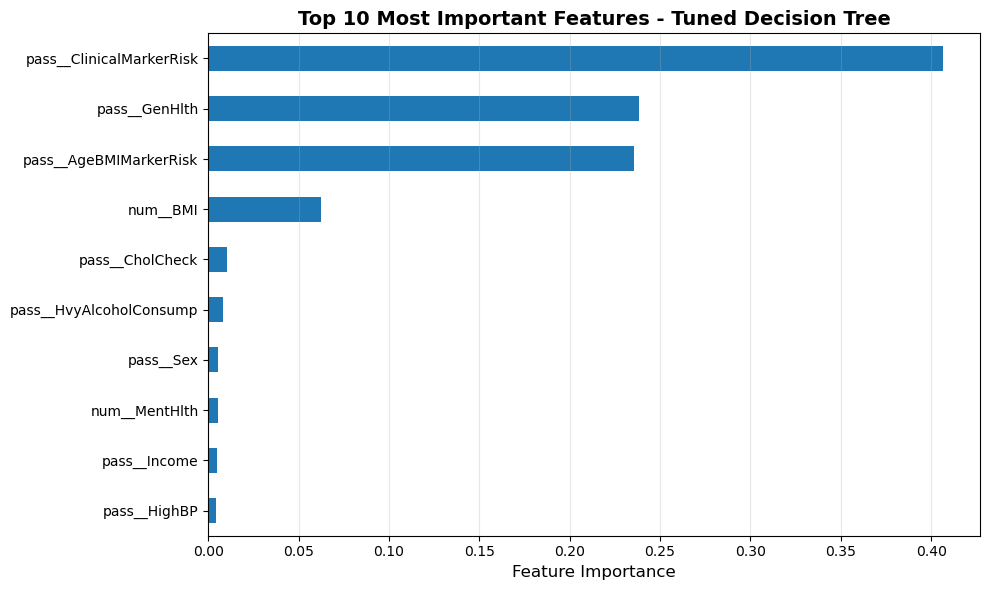

In [22]:
plt.figure(figsize=(10, 6))
importances.head(10).plot(kind='barh')
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Top 10 Most Important Features - Tuned Decision Tree', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig("images/feature_importance_dt.png", dpi=300, bbox_inches='tight')
plt.show()

In [25]:
# The tuned logistic regression  has the  best ROC-AUC score. Lets see its important features

best_lr_pipeline = lr_grid.best_estimator_

# Compute perumation importance of the pipeline
perm_importance = permutation_importance(
    best_lr_pipeline,
    X_test,
    y_test,
    n_repeats=10,  
    scoring='recall', 
    random_state=42,
    n_jobs=-1
)

feature_names = best_lr_pipeline.named_steps["preprocessor"].get_feature_names_out()
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
}).sort_values('Importance', ascending=False)

importance_df

,Feature,Importance,Std
21,pass__AgeBMIMarkerRisk,0.066143,0.002951
18,pass__GenHlth,0.058861,0.002296
19,pass__ClinicalMarkerRisk,0.012978,0.001436
5,pass__CholCheck,0.012805,0.001133
14,pass__HvyAlcoholConsump,0.003417,0.001089
22,pass__BMISedentaryMarkerRisk,0.003244,0.001370
9,pass__Sex,0.003057,0.001021
0,num__BMI,0.002437,0.001074
11,pass__PhysActivity,0.002293,0.001091
3,pass__HighBP,0.001802,0.001355
